# Classification with LeNet-5 CNN architecture

Based on paper "Gradient-Based Learning Applied
to Document Recognition" https://axon.cs.byu.edu/~martinez/classes/678/Papers/Convolution_nets.pdf

Code implementation based on https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/

## Training and evaluating the model

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from PIL import Image
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

Versions:
* python: 3.10
* pytorch-cuda: 11.8

In [6]:
print(torch.__version__)
print(torchvision.__version__)

2.3.0
0.18.0


In [7]:
file_path = 'metadata/metadataTrain.csv'

metadata_train = pd.read_csv(file_path)
metadata_train['CLASS'] -= 1

metadata_train.head()

,ID,CLASS,SEX,AGE,POSITION
0,ISIC_0028766,1,male,30.0,NaN
1,ISIC_0071222,7,male,85.0,lower extremity
2,ISIC_0069434,2,male,85.0,head/neck
3,ISIC_0062098,0,male,55.0,head/neck
4,ISIC_0057224,7,female,45.0,lower extremity


In [8]:
class CustomDataset(Dataset):
    def __init__(self, root, metadata, train, num_channels, transform=None):
        self.metadata = metadata
        self.root = root
        self.train = train
        self.transform = transform
        self.num_channels = num_channels

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        image_filename = self.metadata["ID"][index]

        image = Image.open(
            os.path.join(self.root, image_filename + ".jpg"), formats=["JPEG"]
        ).convert("RGB")

        if self.transform:
            image = self.transform(image)

        image = image[:self.num_channels]

        if self.train:
            label = self.metadata["CLASS"][index]
            return image, label

        return image

In [9]:
learning_rate = 0.0001
n_epochs = 100
batch_size = 64
resize_shape = (32, 32)

train_dir = 'Train'
metadata_file = 'metadata/metadataTest.csv'

img_transform = transforms.Compose([
    transforms.Resize(resize_shape),
    transforms.CenterCrop(28),
    transforms.ToTensor(),
])

# Load the dataset
train_data = CustomDataset(train_dir, metadata_train, train=True, num_channels=3, transform=img_transform)

# separate into train and validation
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size], generator=torch.Generator().manual_seed(0))

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(0), num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4) 

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(1))

cuda
Tesla K80


In [12]:
model = nn.Sequential(
    # Convolutional layers
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    # Flatten the feature maps
    nn.Flatten(),
    
    # Fully connected layers
    nn.Linear(64 * 3 * 3, 128),  # 64 channels * 3x3 feature maps
    nn.ReLU(),
    nn.Linear(128, 8),  # Output layer with 8 classes
    nn.LogSoftmax(dim=1)
)

model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=576, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=8, bias=True)
  (13): LogSoftmax(dim=1)
)

In [68]:
# Assuming train_dataloader is your PyTorch DataLoader
class_weights = [0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745]
criterion = nn.NLLLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to store training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0  # Accumulate loss for the epoch
    epoch_predictions = []
    epoch_labels = []
    
    # Training phase
    with tqdm(train_dataloader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}/{n_epochs}")
        
        for imgs, true_labels in tepoch:
            imgs, true_labels = imgs.to(device), true_labels.to(device)
            
            # Forward pass
            outputs = model(imgs)
            loss = criterion(outputs, true_labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Accumulate the loss
            epoch_loss += loss.item()
            
            # Get predictions and true labels for accuracy calculation
            _, predicted = torch.max(outputs, 1)
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_labels.extend(true_labels.cpu().numpy())
            
            # Update tqdm description with current loss
            tepoch.set_postfix(loss=loss.item())
    
    # Calculate average training loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    train_losses.append(avg_epoch_loss)
    
    # Calculate training accuracy for the epoch
    epoch_accuracy = accuracy_score(epoch_labels, epoch_predictions)
    train_accuracies.append(epoch_accuracy)
    
    # Print training metrics for the epoch
    print(f'Epoch {epoch+1} - Training Loss: {avg_epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}')
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_predictions = []
    val_labels = []
    
    with torch.no_grad():  # Disable gradient computation during validation
        for val_imgs, val_labels_true in val_dataloader:
            val_imgs, val_labels_true = val_imgs.to(device), val_labels_true.to(device)
            
            # Forward pass (validation)
            val_outputs = model(val_imgs)
            val_batch_loss = criterion(val_outputs, val_labels_true)
            val_loss += val_batch_loss.item()
            
            # Get validation predictions and true labels for accuracy calculation
            _, val_predicted = torch.max(val_outputs, 1)
            val_predictions.extend(val_predicted.cpu().numpy())
            val_labels.extend(val_labels_true.cpu().numpy())
    
    # Calculate average validation loss and accuracy for the epoch
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    
    val_accuracy = accuracy_score(val_labels, val_predictions)
    val_accuracies.append(val_accuracy)
    
    # Print validation metrics for the epoch
    print(f'Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch 1/100:   0%|          | 0/238 [00:00<?, ?batch/s]

Epoch 1/100: 100%|██████████| 238/238 [00:59<00:00,  3.98batch/s, loss=1.93]

Epoch 1 - Training Loss: 2.0763, Training Accuracy: 0.1689


Epoch 1 - Validation Loss: 2.0160, Validation Accuracy: 0.4258


Epoch 2/100: 100%|██████████| 238/238 [00:21<00:00, 10.89batch/s, loss=1.99]

Epoch 2 - Training Loss: 1.9634, Training Accuracy: 0.3704


Epoch 2 - Validation Loss: 1.9276, Validation Accuracy: 0.3334


Epoch 3/100: 100%|██████████| 238/238 [00:17<00:00, 13.58batch/s, loss=1.98]

Epoch 3 - Training Loss: 1.9166, Training Accuracy: 0.3790


Epoch 3 - Validation Loss: 1.8559, Validation Accuracy: 0.4195


Epoch 4/100: 100%|██████████| 238/238 [00:17<00:00, 13.83batch/s, loss=1.98]

Epoch 4 - Training Loss: 1.8753, Training Accuracy: 0.3834


Epoch 4 - Validation Loss: 1.8284, Validation Accuracy: 0.3421


Epoch 5/100: 100%|██████████| 238/238 [00:17<00:00, 13.69batch/s, loss=1.63]

Epoch 5 - Training Loss: 1.8524, Training Accuracy: 0.3357


Epoch 5 - Validation Loss: 1.8145, Validation Accuracy: 0.3629


Epoch 6/100: 100%|██████████| 238/238 [00:17<00:00, 13.55batch/s, loss=1.76]

Epoch 6 - Training Loss: 1.8030, Training Accuracy: 0.3127


Epoch 6 - Validation Loss: 1.7717, Validation Accuracy: 0.3547


Epoch 7/100: 100%|██████████| 238/238 [00:17<00:00, 13.82batch/s, loss=1.86]

Epoch 7 - Training Loss: 1.7510, Training Accuracy: 0.3583


Epoch 7 - Validation Loss: 1.7447, Validation Accuracy: 0.3658


Epoch 8/100: 100%|██████████| 238/238 [00:17<00:00, 13.98batch/s, loss=2]   

Epoch 8 - Training Loss: 1.7258, Training Accuracy: 0.3783


Epoch 8 - Validation Loss: 1.7280, Validation Accuracy: 0.3866


Epoch 9/100: 100%|██████████| 238/238 [00:17<00:00, 13.87batch/s, loss=1.64]

Epoch 9 - Training Loss: 1.6903, Training Accuracy: 0.3991


Epoch 9 - Validation Loss: 1.7082, Validation Accuracy: 0.3724


Epoch 10/100: 100%|██████████| 238/238 [00:17<00:00, 13.74batch/s, loss=1.84] 


Epoch 10 - Training Loss: 1.6880, Training Accuracy: 0.3979
Epoch 10 - Validation Loss: 1.7156, Validation Accuracy: 0.3558


Epoch 11/100: 100%|██████████| 238/238 [00:16<00:00, 14.59batch/s, loss=1.79]


Epoch 11 - Training Loss: 1.6691, Training Accuracy: 0.4014
Epoch 11 - Validation Loss: 1.6811, Validation Accuracy: 0.4258


Epoch 12/100: 100%|██████████| 238/238 [00:16<00:00, 14.31batch/s, loss=1.03] 

Epoch 12 - Training Loss: 1.6393, Training Accuracy: 0.4253


Epoch 12 - Validation Loss: 1.6840, Validation Accuracy: 0.4134


Epoch 13/100: 100%|██████████| 238/238 [00:17<00:00, 13.93batch/s, loss=0.903]

Epoch 13 - Training Loss: 1.6339, Training Accuracy: 0.4203


Epoch 13 - Validation Loss: 1.6430, Validation Accuracy: 0.4234


Epoch 14/100: 100%|██████████| 238/238 [00:17<00:00, 13.51batch/s, loss=1.3]  

Epoch 14 - Training Loss: 1.6090, Training Accuracy: 0.4418


Epoch 14 - Validation Loss: 1.6569, Validation Accuracy: 0.4532


Epoch 15/100: 100%|██████████| 238/238 [00:17<00:00, 13.89batch/s, loss=1.9] 

Epoch 15 - Training Loss: 1.6166, Training Accuracy: 0.4333


Epoch 15 - Validation Loss: 1.6772, Validation Accuracy: 0.4092


Epoch 16/100: 100%|██████████| 238/238 [00:17<00:00, 13.78batch/s, loss=1.67] 

Epoch 16 - Training Loss: 1.5926, Training Accuracy: 0.4445


Epoch 16 - Validation Loss: 1.6227, Validation Accuracy: 0.4145


Epoch 17/100: 100%|██████████| 238/238 [00:18<00:00, 13.06batch/s, loss=1.78] 

Epoch 17 - Training Loss: 1.6006, Training Accuracy: 0.4226


Epoch 17 - Validation Loss: 1.6261, Validation Accuracy: 0.3803


Epoch 18/100: 100%|██████████| 238/238 [00:17<00:00, 13.78batch/s, loss=1.63] 

Epoch 18 - Training Loss: 1.5708, Training Accuracy: 0.4312


Epoch 18 - Validation Loss: 1.6419, Validation Accuracy: 0.4139


Epoch 19/100: 100%|██████████| 238/238 [00:16<00:00, 14.06batch/s, loss=1.77] 

Epoch 19 - Training Loss: 1.5593, Training Accuracy: 0.4416


Epoch 19 - Validation Loss: 1.5941, Validation Accuracy: 0.4676


Epoch 20/100: 100%|██████████| 238/238 [00:17<00:00, 13.42batch/s, loss=0.99]

Epoch 20 - Training Loss: 1.5606, Training Accuracy: 0.4348


Epoch 20 - Validation Loss: 1.5822, Validation Accuracy: 0.4508


Epoch 21/100: 100%|██████████| 238/238 [00:17<00:00, 13.79batch/s, loss=1.58] 

Epoch 21 - Training Loss: 1.5452, Training Accuracy: 0.4470


Epoch 21 - Validation Loss: 1.6141, Validation Accuracy: 0.4111


Epoch 22/100: 100%|██████████| 238/238 [00:17<00:00, 13.84batch/s, loss=1.42] 

Epoch 22 - Training Loss: 1.5298, Training Accuracy: 0.4366


Epoch 22 - Validation Loss: 1.6000, Validation Accuracy: 0.4079


Epoch 23/100: 100%|██████████| 238/238 [00:16<00:00, 14.64batch/s, loss=1.16] 

Epoch 23 - Training Loss: 1.5470, Training Accuracy: 0.4378


Epoch 23 - Validation Loss: 1.6211, Validation Accuracy: 0.4268


Epoch 24/100: 100%|██████████| 238/238 [00:17<00:00, 13.60batch/s, loss=1.84] 

Epoch 24 - Training Loss: 1.5263, Training Accuracy: 0.4457


Epoch 24 - Validation Loss: 1.5818, Validation Accuracy: 0.4200


Epoch 25/100: 100%|██████████| 238/238 [00:17<00:00, 13.41batch/s, loss=1.72] 

Epoch 25 - Training Loss: 1.5145, Training Accuracy: 0.4444


Epoch 25 - Validation Loss: 1.5584, Validation Accuracy: 0.4266


Epoch 26/100: 100%|██████████| 238/238 [00:17<00:00, 13.83batch/s, loss=1.63] 

Epoch 26 - Training Loss: 1.5060, Training Accuracy: 0.4386


Epoch 26 - Validation Loss: 1.5522, Validation Accuracy: 0.4542


Epoch 27/100: 100%|██████████| 238/238 [00:17<00:00, 13.97batch/s, loss=1.66] 

Epoch 27 - Training Loss: 1.5096, Training Accuracy: 0.4455


Epoch 27 - Validation Loss: 1.5797, Validation Accuracy: 0.4453


Epoch 28/100: 100%|██████████| 238/238 [00:17<00:00, 13.78batch/s, loss=1.39] 

Epoch 28 - Training Loss: 1.5054, Training Accuracy: 0.4458


Epoch 28 - Validation Loss: 1.5588, Validation Accuracy: 0.4353


Epoch 29/100: 100%|██████████| 238/238 [00:17<00:00, 13.92batch/s, loss=1.85] 

Epoch 29 - Training Loss: 1.4832, Training Accuracy: 0.4441


Epoch 29 - Validation Loss: 1.5700, Validation Accuracy: 0.4576


Epoch 30/100: 100%|██████████| 238/238 [00:16<00:00, 14.57batch/s, loss=1.06] 

Epoch 30 - Training Loss: 1.4862, Training Accuracy: 0.4518


Epoch 30 - Validation Loss: 1.5476, Validation Accuracy: 0.4332


Epoch 31/100: 100%|██████████| 238/238 [00:17<00:00, 13.49batch/s, loss=1.29] 

Epoch 31 - Training Loss: 1.4833, Training Accuracy: 0.4362


Epoch 31 - Validation Loss: 1.5282, Validation Accuracy: 0.4389


Epoch 32/100: 100%|██████████| 238/238 [00:16<00:00, 14.13batch/s, loss=1.32] 

Epoch 32 - Training Loss: 1.4617, Training Accuracy: 0.4497


Epoch 32 - Validation Loss: 1.5367, Validation Accuracy: 0.4408


Epoch 33/100: 100%|██████████| 238/238 [00:17<00:00, 13.58batch/s, loss=1.32] 

Epoch 33 - Training Loss: 1.4594, Training Accuracy: 0.4447


Epoch 33 - Validation Loss: 1.5449, Validation Accuracy: 0.4742


Epoch 34/100: 100%|██████████| 238/238 [00:18<00:00, 12.59batch/s, loss=1.27] 

Epoch 34 - Training Loss: 1.4466, Training Accuracy: 0.4531


Epoch 34 - Validation Loss: 1.5289, Validation Accuracy: 0.4526


Epoch 35/100: 100%|██████████| 238/238 [00:16<00:00, 14.26batch/s, loss=1.74] 

Epoch 35 - Training Loss: 1.4621, Training Accuracy: 0.4407


Epoch 35 - Validation Loss: 1.5334, Validation Accuracy: 0.4363


Epoch 36/100: 100%|██████████| 238/238 [00:16<00:00, 14.42batch/s, loss=1.45] 

Epoch 36 - Training Loss: 1.4253, Training Accuracy: 0.4570


Epoch 36 - Validation Loss: 1.5454, Validation Accuracy: 0.4429


Epoch 37/100: 100%|██████████| 238/238 [00:17<00:00, 13.25batch/s, loss=1.8]  

Epoch 37 - Training Loss: 1.4621, Training Accuracy: 0.4356


Epoch 37 - Validation Loss: 1.5116, Validation Accuracy: 0.4329


Epoch 38/100: 100%|██████████| 238/238 [00:17<00:00, 13.83batch/s, loss=1.67] 

Epoch 38 - Training Loss: 1.4185, Training Accuracy: 0.4470


Epoch 38 - Validation Loss: 1.5162, Validation Accuracy: 0.4250


Epoch 39/100: 100%|██████████| 238/238 [00:17<00:00, 13.41batch/s, loss=1.33] 

Epoch 39 - Training Loss: 1.4359, Training Accuracy: 0.4490


Epoch 39 - Validation Loss: 1.5076, Validation Accuracy: 0.4471


Epoch 40/100: 100%|██████████| 238/238 [00:17<00:00, 13.55batch/s, loss=1.5]  

Epoch 40 - Training Loss: 1.4132, Training Accuracy: 0.4435


Epoch 40 - Validation Loss: 1.5163, Validation Accuracy: 0.4339


Epoch 41/100: 100%|██████████| 238/238 [00:17<00:00, 13.89batch/s, loss=1.34] 

Epoch 41 - Training Loss: 1.4393, Training Accuracy: 0.4516


Epoch 41 - Validation Loss: 1.5208, Validation Accuracy: 0.4411


Epoch 42/100: 100%|██████████| 238/238 [00:18<00:00, 13.01batch/s, loss=1.03] 

Epoch 42 - Training Loss: 1.4079, Training Accuracy: 0.4468


Epoch 42 - Validation Loss: 1.4732, Validation Accuracy: 0.4321


Epoch 43/100: 100%|██████████| 238/238 [00:17<00:00, 13.90batch/s, loss=1.3]  

Epoch 43 - Training Loss: 1.3988, Training Accuracy: 0.4550


Epoch 43 - Validation Loss: 1.4603, Validation Accuracy: 0.4382


Epoch 44/100: 100%|██████████| 238/238 [00:17<00:00, 13.69batch/s, loss=1.65] 

Epoch 44 - Training Loss: 1.4062, Training Accuracy: 0.4456


Epoch 44 - Validation Loss: 1.5112, Validation Accuracy: 0.3697


Epoch 45/100: 100%|██████████| 238/238 [00:17<00:00, 13.37batch/s, loss=1.42] 


Epoch 45 - Training Loss: 1.3831, Training Accuracy: 0.4514
Epoch 45 - Validation Loss: 1.4637, Validation Accuracy: 0.4455


Epoch 46/100: 100%|██████████| 238/238 [00:17<00:00, 13.83batch/s, loss=1.37] 

Epoch 46 - Training Loss: 1.3799, Training Accuracy: 0.4536


Epoch 46 - Validation Loss: 1.4691, Validation Accuracy: 0.4542


Epoch 47/100: 100%|██████████| 238/238 [00:16<00:00, 14.01batch/s, loss=1.13] 

Epoch 47 - Training Loss: 1.3846, Training Accuracy: 0.4520


Epoch 47 - Validation Loss: 1.4985, Validation Accuracy: 0.4513


Epoch 48/100: 100%|██████████| 238/238 [00:17<00:00, 13.81batch/s, loss=1.62] 

Epoch 48 - Training Loss: 1.4027, Training Accuracy: 0.4551


Epoch 48 - Validation Loss: 1.4900, Validation Accuracy: 0.4597


Epoch 49/100: 100%|██████████| 238/238 [00:17<00:00, 13.77batch/s, loss=2.7]  

Epoch 49 - Training Loss: 1.3759, Training Accuracy: 0.4626


Epoch 49 - Validation Loss: 1.4859, Validation Accuracy: 0.4584


Epoch 50/100: 100%|██████████| 238/238 [00:17<00:00, 13.72batch/s, loss=1.25] 

Epoch 50 - Training Loss: 1.3541, Training Accuracy: 0.4625


Epoch 50 - Validation Loss: 1.4726, Validation Accuracy: 0.4579


Epoch 51/100: 100%|██████████| 238/238 [00:16<00:00, 14.17batch/s, loss=1.52] 

Epoch 51 - Training Loss: 1.3569, Training Accuracy: 0.4621


Epoch 51 - Validation Loss: 1.5053, Validation Accuracy: 0.4461


Epoch 52/100: 100%|██████████| 238/238 [00:16<00:00, 14.30batch/s, loss=1.2]  

Epoch 52 - Training Loss: 1.3543, Training Accuracy: 0.4689


Epoch 52 - Validation Loss: 1.4641, Validation Accuracy: 0.4395


Epoch 53/100: 100%|██████████| 238/238 [00:16<00:00, 14.07batch/s, loss=0.908]

Epoch 53 - Training Loss: 1.3473, Training Accuracy: 0.4585


Epoch 53 - Validation Loss: 1.4605, Validation Accuracy: 0.4645


Epoch 54/100: 100%|██████████| 238/238 [00:16<00:00, 14.10batch/s, loss=1.85] 

Epoch 54 - Training Loss: 1.3700, Training Accuracy: 0.4571


Epoch 54 - Validation Loss: 1.5191, Validation Accuracy: 0.4463


Epoch 55/100: 100%|██████████| 238/238 [00:17<00:00, 13.73batch/s, loss=1.39] 


Epoch 55 - Training Loss: 1.3633, Training Accuracy: 0.4585
Epoch 55 - Validation Loss: 1.5443, Validation Accuracy: 0.3650


Epoch 56/100: 100%|██████████| 238/238 [00:17<00:00, 13.89batch/s, loss=1.5]  

Epoch 56 - Training Loss: 1.3559, Training Accuracy: 0.4653


Epoch 56 - Validation Loss: 1.4694, Validation Accuracy: 0.4282


Epoch 57/100: 100%|██████████| 238/238 [00:12<00:00, 19.57batch/s, loss=0.853]

Epoch 57 - Training Loss: 1.3343, Training Accuracy: 0.4696


Epoch 57 - Validation Loss: 1.4479, Validation Accuracy: 0.4024


Epoch 58/100: 100%|██████████| 238/238 [00:10<00:00, 23.09batch/s, loss=1.78] 

Epoch 58 - Training Loss: 1.3260, Training Accuracy: 0.4605


Epoch 58 - Validation Loss: 1.4738, Validation Accuracy: 0.4534


Epoch 59/100: 100%|██████████| 238/238 [00:10<00:00, 22.61batch/s, loss=1.12] 

Epoch 59 - Training Loss: 1.3161, Training Accuracy: 0.4699


Epoch 59 - Validation Loss: 1.4640, Validation Accuracy: 0.4250


Epoch 60/100: 100%|██████████| 238/238 [00:10<00:00, 22.42batch/s, loss=1.55] 

Epoch 60 - Training Loss: 1.3215, Training Accuracy: 0.4609


Epoch 60 - Validation Loss: 1.4616, Validation Accuracy: 0.4547


Epoch 61/100: 100%|██████████| 238/238 [00:10<00:00, 22.97batch/s, loss=0.688]

Epoch 61 - Training Loss: 1.3037, Training Accuracy: 0.4699


Epoch 61 - Validation Loss: 1.4902, Validation Accuracy: 0.4447


Epoch 62/100: 100%|██████████| 238/238 [00:14<00:00, 16.35batch/s, loss=1.39] 

Epoch 62 - Training Loss: 1.3144, Training Accuracy: 0.4613


Epoch 62 - Validation Loss: 1.4592, Validation Accuracy: 0.4639


Epoch 63/100: 100%|██████████| 238/238 [00:16<00:00, 14.10batch/s, loss=0.958]

Epoch 63 - Training Loss: 1.3510, Training Accuracy: 0.4541


Epoch 63 - Validation Loss: 1.4432, Validation Accuracy: 0.4766


Epoch 64/100: 100%|██████████| 238/238 [00:17<00:00, 13.74batch/s, loss=1.2]  

Epoch 64 - Training Loss: 1.3093, Training Accuracy: 0.4748


Epoch 64 - Validation Loss: 1.4503, Validation Accuracy: 0.4084


Epoch 65/100: 100%|██████████| 238/238 [00:17<00:00, 13.70batch/s, loss=1.02] 

Epoch 65 - Training Loss: 1.2999, Training Accuracy: 0.4695


Epoch 65 - Validation Loss: 1.4803, Validation Accuracy: 0.4716


Epoch 66/100: 100%|██████████| 238/238 [00:17<00:00, 13.84batch/s, loss=0.954]

Epoch 66 - Training Loss: 1.2907, Training Accuracy: 0.4759


Epoch 66 - Validation Loss: 1.4751, Validation Accuracy: 0.4571


Epoch 67/100: 100%|██████████| 238/238 [00:13<00:00, 18.29batch/s, loss=1.01] 

Epoch 67 - Training Loss: 1.2721, Training Accuracy: 0.4749


Epoch 67 - Validation Loss: 1.4818, Validation Accuracy: 0.4934


Epoch 68/100: 100%|██████████| 238/238 [00:10<00:00, 22.79batch/s, loss=1.63] 

Epoch 68 - Training Loss: 1.3119, Training Accuracy: 0.4651


Epoch 68 - Validation Loss: 1.4540, Validation Accuracy: 0.4734


Epoch 69/100: 100%|██████████| 238/238 [00:10<00:00, 22.64batch/s, loss=1.08] 

Epoch 69 - Training Loss: 1.2855, Training Accuracy: 0.4724


Epoch 69 - Validation Loss: 1.4524, Validation Accuracy: 0.4484


Epoch 70/100: 100%|██████████| 238/238 [00:10<00:00, 22.77batch/s, loss=1.92] 

Epoch 70 - Training Loss: 1.2981, Training Accuracy: 0.4693


Epoch 70 - Validation Loss: 1.4606, Validation Accuracy: 0.4392


Epoch 71/100: 100%|██████████| 238/238 [00:10<00:00, 22.09batch/s, loss=1.18] 

Epoch 71 - Training Loss: 1.3018, Training Accuracy: 0.4688


Epoch 71 - Validation Loss: 1.4518, Validation Accuracy: 0.4466


Epoch 72/100: 100%|██████████| 238/238 [00:10<00:00, 21.88batch/s, loss=1.17] 


Epoch 72 - Training Loss: 1.2949, Training Accuracy: 0.4745
Epoch 72 - Validation Loss: 1.4644, Validation Accuracy: 0.4592


Epoch 73/100: 100%|██████████| 238/238 [00:10<00:00, 22.90batch/s, loss=0.857]

Epoch 73 - Training Loss: 1.2587, Training Accuracy: 0.4789


Epoch 73 - Validation Loss: 1.4695, Validation Accuracy: 0.4171


Epoch 74/100: 100%|██████████| 238/238 [00:10<00:00, 22.91batch/s, loss=2.04] 


Epoch 74 - Training Loss: 1.2835, Training Accuracy: 0.4749
Epoch 74 - Validation Loss: 1.5537, Validation Accuracy: 0.4724


Epoch 75/100: 100%|██████████| 238/238 [00:10<00:00, 22.12batch/s, loss=1.33] 

Epoch 75 - Training Loss: 1.2648, Training Accuracy: 0.4828


Epoch 75 - Validation Loss: 1.4988, Validation Accuracy: 0.4711


Epoch 76/100: 100%|██████████| 238/238 [00:10<00:00, 23.03batch/s, loss=1.45] 

Epoch 76 - Training Loss: 1.2548, Training Accuracy: 0.4803


Epoch 76 - Validation Loss: 1.4477, Validation Accuracy: 0.4555


Epoch 77/100: 100%|██████████| 238/238 [00:11<00:00, 21.10batch/s, loss=1.63] 

Epoch 77 - Training Loss: 1.2458, Training Accuracy: 0.4801


Epoch 77 - Validation Loss: 1.4336, Validation Accuracy: 0.4945


Epoch 78/100: 100%|██████████| 238/238 [00:14<00:00, 16.68batch/s, loss=1.68] 

Epoch 78 - Training Loss: 1.2823, Training Accuracy: 0.4620


Epoch 78 - Validation Loss: 1.5363, Validation Accuracy: 0.4474


Epoch 79/100: 100%|██████████| 238/238 [00:17<00:00, 13.78batch/s, loss=1.16] 

Epoch 79 - Training Loss: 1.2960, Training Accuracy: 0.4689


Epoch 79 - Validation Loss: 1.5037, Validation Accuracy: 0.4700


Epoch 80/100: 100%|██████████| 238/238 [00:18<00:00, 12.69batch/s, loss=1.6]  

Epoch 80 - Training Loss: 1.2614, Training Accuracy: 0.4734


Epoch 80 - Validation Loss: 1.4722, Validation Accuracy: 0.3650


Epoch 81/100: 100%|██████████| 238/238 [00:17<00:00, 13.50batch/s, loss=0.59] 

Epoch 81 - Training Loss: 1.2376, Training Accuracy: 0.4799


Epoch 81 - Validation Loss: 1.4621, Validation Accuracy: 0.4439


Epoch 82/100: 100%|██████████| 238/238 [00:18<00:00, 13.20batch/s, loss=1.12] 

Epoch 82 - Training Loss: 1.2378, Training Accuracy: 0.4791


Epoch 82 - Validation Loss: 1.4521, Validation Accuracy: 0.4463


Epoch 83/100: 100%|██████████| 238/238 [00:17<00:00, 13.84batch/s, loss=0.715]


Epoch 83 - Training Loss: 1.2301, Training Accuracy: 0.4792
Epoch 83 - Validation Loss: 1.4731, Validation Accuracy: 0.4471


Epoch 84/100: 100%|██████████| 238/238 [00:18<00:00, 13.04batch/s, loss=0.895]

Epoch 84 - Training Loss: 1.2343, Training Accuracy: 0.4799


Epoch 84 - Validation Loss: 1.4399, Validation Accuracy: 0.4800


Epoch 85/100: 100%|██████████| 238/238 [00:18<00:00, 13.05batch/s, loss=0.888]

Epoch 85 - Training Loss: 1.2314, Training Accuracy: 0.4787


Epoch 85 - Validation Loss: 1.4869, Validation Accuracy: 0.4587


Epoch 86/100: 100%|██████████| 238/238 [00:16<00:00, 14.01batch/s, loss=1.14] 

Epoch 86 - Training Loss: 1.2390, Training Accuracy: 0.4855


Epoch 86 - Validation Loss: 1.4170, Validation Accuracy: 0.4666


Epoch 87/100: 100%|██████████| 238/238 [00:17<00:00, 13.86batch/s, loss=1.54] 

Epoch 87 - Training Loss: 1.2312, Training Accuracy: 0.4863


Epoch 87 - Validation Loss: 1.4314, Validation Accuracy: 0.4421


Epoch 88/100: 100%|██████████| 238/238 [00:17<00:00, 13.59batch/s, loss=0.796]

Epoch 88 - Training Loss: 1.2347, Training Accuracy: 0.4748


Epoch 88 - Validation Loss: 1.4956, Validation Accuracy: 0.4895


Epoch 89/100: 100%|██████████| 238/238 [00:16<00:00, 14.48batch/s, loss=1.35] 

Epoch 89 - Training Loss: 1.2256, Training Accuracy: 0.4805


Epoch 89 - Validation Loss: 1.4706, Validation Accuracy: 0.4355


Epoch 90/100: 100%|██████████| 238/238 [00:17<00:00, 13.84batch/s, loss=1.02] 

Epoch 90 - Training Loss: 1.2369, Training Accuracy: 0.4741


Epoch 90 - Validation Loss: 1.4706, Validation Accuracy: 0.4382


Epoch 91/100: 100%|██████████| 238/238 [00:16<00:00, 14.38batch/s, loss=1.42] 

Epoch 91 - Training Loss: 1.2219, Training Accuracy: 0.4732


Epoch 91 - Validation Loss: 1.4483, Validation Accuracy: 0.4792


Epoch 92/100: 100%|██████████| 238/238 [00:17<00:00, 13.83batch/s, loss=1.3]  

Epoch 92 - Training Loss: 1.1977, Training Accuracy: 0.4942


Epoch 92 - Validation Loss: 1.4730, Validation Accuracy: 0.4774


Epoch 93/100: 100%|██████████| 238/238 [00:18<00:00, 12.82batch/s, loss=1.41] 

Epoch 93 - Training Loss: 1.2226, Training Accuracy: 0.4777


Epoch 93 - Validation Loss: 1.4510, Validation Accuracy: 0.4626


Epoch 94/100: 100%|██████████| 238/238 [00:18<00:00, 13.20batch/s, loss=0.898]

Epoch 94 - Training Loss: 1.1989, Training Accuracy: 0.4890


Epoch 94 - Validation Loss: 1.4803, Validation Accuracy: 0.4753


Epoch 95/100: 100%|██████████| 238/238 [00:17<00:00, 13.38batch/s, loss=1.09] 

Epoch 95 - Training Loss: 1.2197, Training Accuracy: 0.4824


Epoch 95 - Validation Loss: 1.5766, Validation Accuracy: 0.4992


Epoch 96/100: 100%|██████████| 238/238 [00:17<00:00, 13.28batch/s, loss=2.31] 

Epoch 96 - Training Loss: 1.2103, Training Accuracy: 0.4806


Epoch 96 - Validation Loss: 1.5310, Validation Accuracy: 0.4426


Epoch 97/100: 100%|██████████| 238/238 [00:16<00:00, 14.00batch/s, loss=1.19] 

Epoch 97 - Training Loss: 1.2483, Training Accuracy: 0.4838


Epoch 97 - Validation Loss: 1.5290, Validation Accuracy: 0.4676


Epoch 98/100: 100%|██████████| 238/238 [00:16<00:00, 14.48batch/s, loss=2.02] 


Epoch 98 - Training Loss: 1.2959, Training Accuracy: 0.4603
Epoch 98 - Validation Loss: 1.4140, Validation Accuracy: 0.4339


Epoch 99/100: 100%|██████████| 238/238 [00:17<00:00, 13.89batch/s, loss=1.35] 


Epoch 99 - Training Loss: 1.2084, Training Accuracy: 0.4820
Epoch 99 - Validation Loss: 1.4912, Validation Accuracy: 0.4855


Epoch 100/100: 100%|██████████| 238/238 [00:16<00:00, 14.45batch/s, loss=1.21] 

Epoch 100 - Training Loss: 1.2182, Training Accuracy: 0.4838


Epoch 100 - Validation Loss: 1.4748, Validation Accuracy: 0.4839


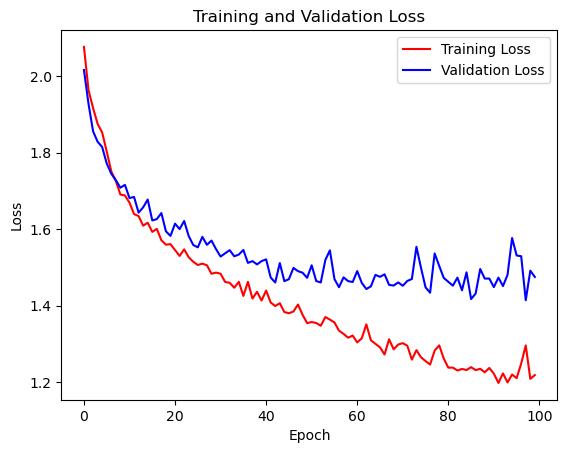

In [70]:
plt.title('Training and Validation Loss')
plt.plot(train_losses, label='Training Loss', color='r')
plt.plot(val_losses, label='Validation Loss', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
torch.save(model, 'model_lenet.pth')

In [26]:
target_names = [
    'Melanoma',
    'Melanocytic nevus',
    'Basal cell carcinoma',
    'Actinic keratosis',
    'Benign keratosis',
    'Dermatofibroma',
    'Vascular lesion',
    'Squamous cell carcinoma'
]

class_weights = [0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745]

def weighted_accuracy(y_true, y_pred, class_weights):
    weighted_acc = 0.0
    total_weights = 0.0
    
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            weighted_acc += class_weights[int(y_true[i] - 1)]
        total_weights += class_weights[int(y_true[i] - 1)]
    
    weighted_acc /= total_weights
    
    return weighted_acc

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
checkpoint_path = 'model_lenet.pth'
model = torch.load(checkpoint_path, map_location=device)

model.eval()

pred_train_labels = []
train_labels = []

for images, labels in train_dataloader:
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)
    train_labels.extend(labels.cpu().numpy())  
    pred_train_labels.extend(predicted_labels.cpu().numpy())

pred_val_labels = []
val_labels = []

for images, labels in val_dataloader:
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)
    val_labels.extend(labels.cpu().numpy())
    pred_val_labels.extend(predicted_labels.cpu().numpy())


pred_train_labels = np.array(pred_train_labels) + 1
train_labels = np.array(train_labels) + 1
pred_val_labels = np.array(pred_val_labels) + 1
val_labels = np.array(val_labels) + 1

cuda


In [27]:
# Generate and print classification reports
report = classification_report(train_labels, pred_train_labels, target_names=target_names)
print("Train Classification Report:")
print(report)

report = classification_report(val_labels, pred_val_labels, target_names=target_names)
print("Validation Classification Report:")
print(report)

# Calculate train weighted accuracy
train_weighted_acc = weighted_accuracy(train_labels, pred_train_labels, class_weights)
print("Train Weighted Accuracy:", train_weighted_acc)

# Calculate validation weighted accuracy
validation_weighted_acc = weighted_accuracy(val_labels, pred_val_labels, class_weights)
print("Validation Weighted Accuracy:", validation_weighted_acc)

Train Classification Report:
                         precision    recall  f1-score   support

               Melanoma       0.55      0.46      0.50      2700
      Melanocytic nevus       0.85      0.71      0.77      7733
   Basal cell carcinoma       0.59      0.46      0.52      1974
      Actinic keratosis       0.28      0.59      0.38       510
       Benign keratosis       0.37      0.37      0.37      1600
         Dermatofibroma       0.13      0.97      0.23       142
        Vascular lesion       0.43      0.99      0.60       158
Squamous cell carcinoma       0.28      0.62      0.39       381

               accuracy                           0.60     15198
              macro avg       0.44      0.65      0.47     15198
           weighted avg       0.67      0.60      0.62     15198

Validation Classification Report:
                         precision    recall  f1-score   support

               Melanoma       0.47      0.38      0.42       691
      Melanocytic nevus

## Classification of the images in Test set

In [43]:
# Generate test results csv
file_path = 'metadata/metadataTest.csv'
metadata_test = pd.read_csv(file_path)
#print(metadata_test.head())

test_dir = 'Test'
test_data = CustomDataset(test_dir, metadata_test, train=False, num_channels=3, transform=img_transform)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

# Set the model to evaluation mode
model.eval()

# Make predictions for the test data
predictions = []
for images in test_dataloader:
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)
    predictions.extend(predicted_labels.cpu().numpy())

predictions = np.array(predictions) + 1

# Convert the predicted labels to a pandas DataFrame
test_results = pd.DataFrame({'ID': metadata_test['ID'], 'CLASS': predictions})

# Save the DataFrame to a CSV file
test_results.to_csv('test_results_cnn.csv', index=False)